### Introduction

In this notebook, we will go over the concept of Trace in thunder. We will first do a top down view where we will dissect a trace generated from thunder into it's components. Once we understand what makes a trace, we will generate our create our own trace from these components.

A thunder trace represents the program using the representation that thunder understands. It is easy to print a `trace` and see what the computation looks like.

This is the picture that we will be referring while going through the notebook. This picture may look a bit intimidating but let's break it down one by one.

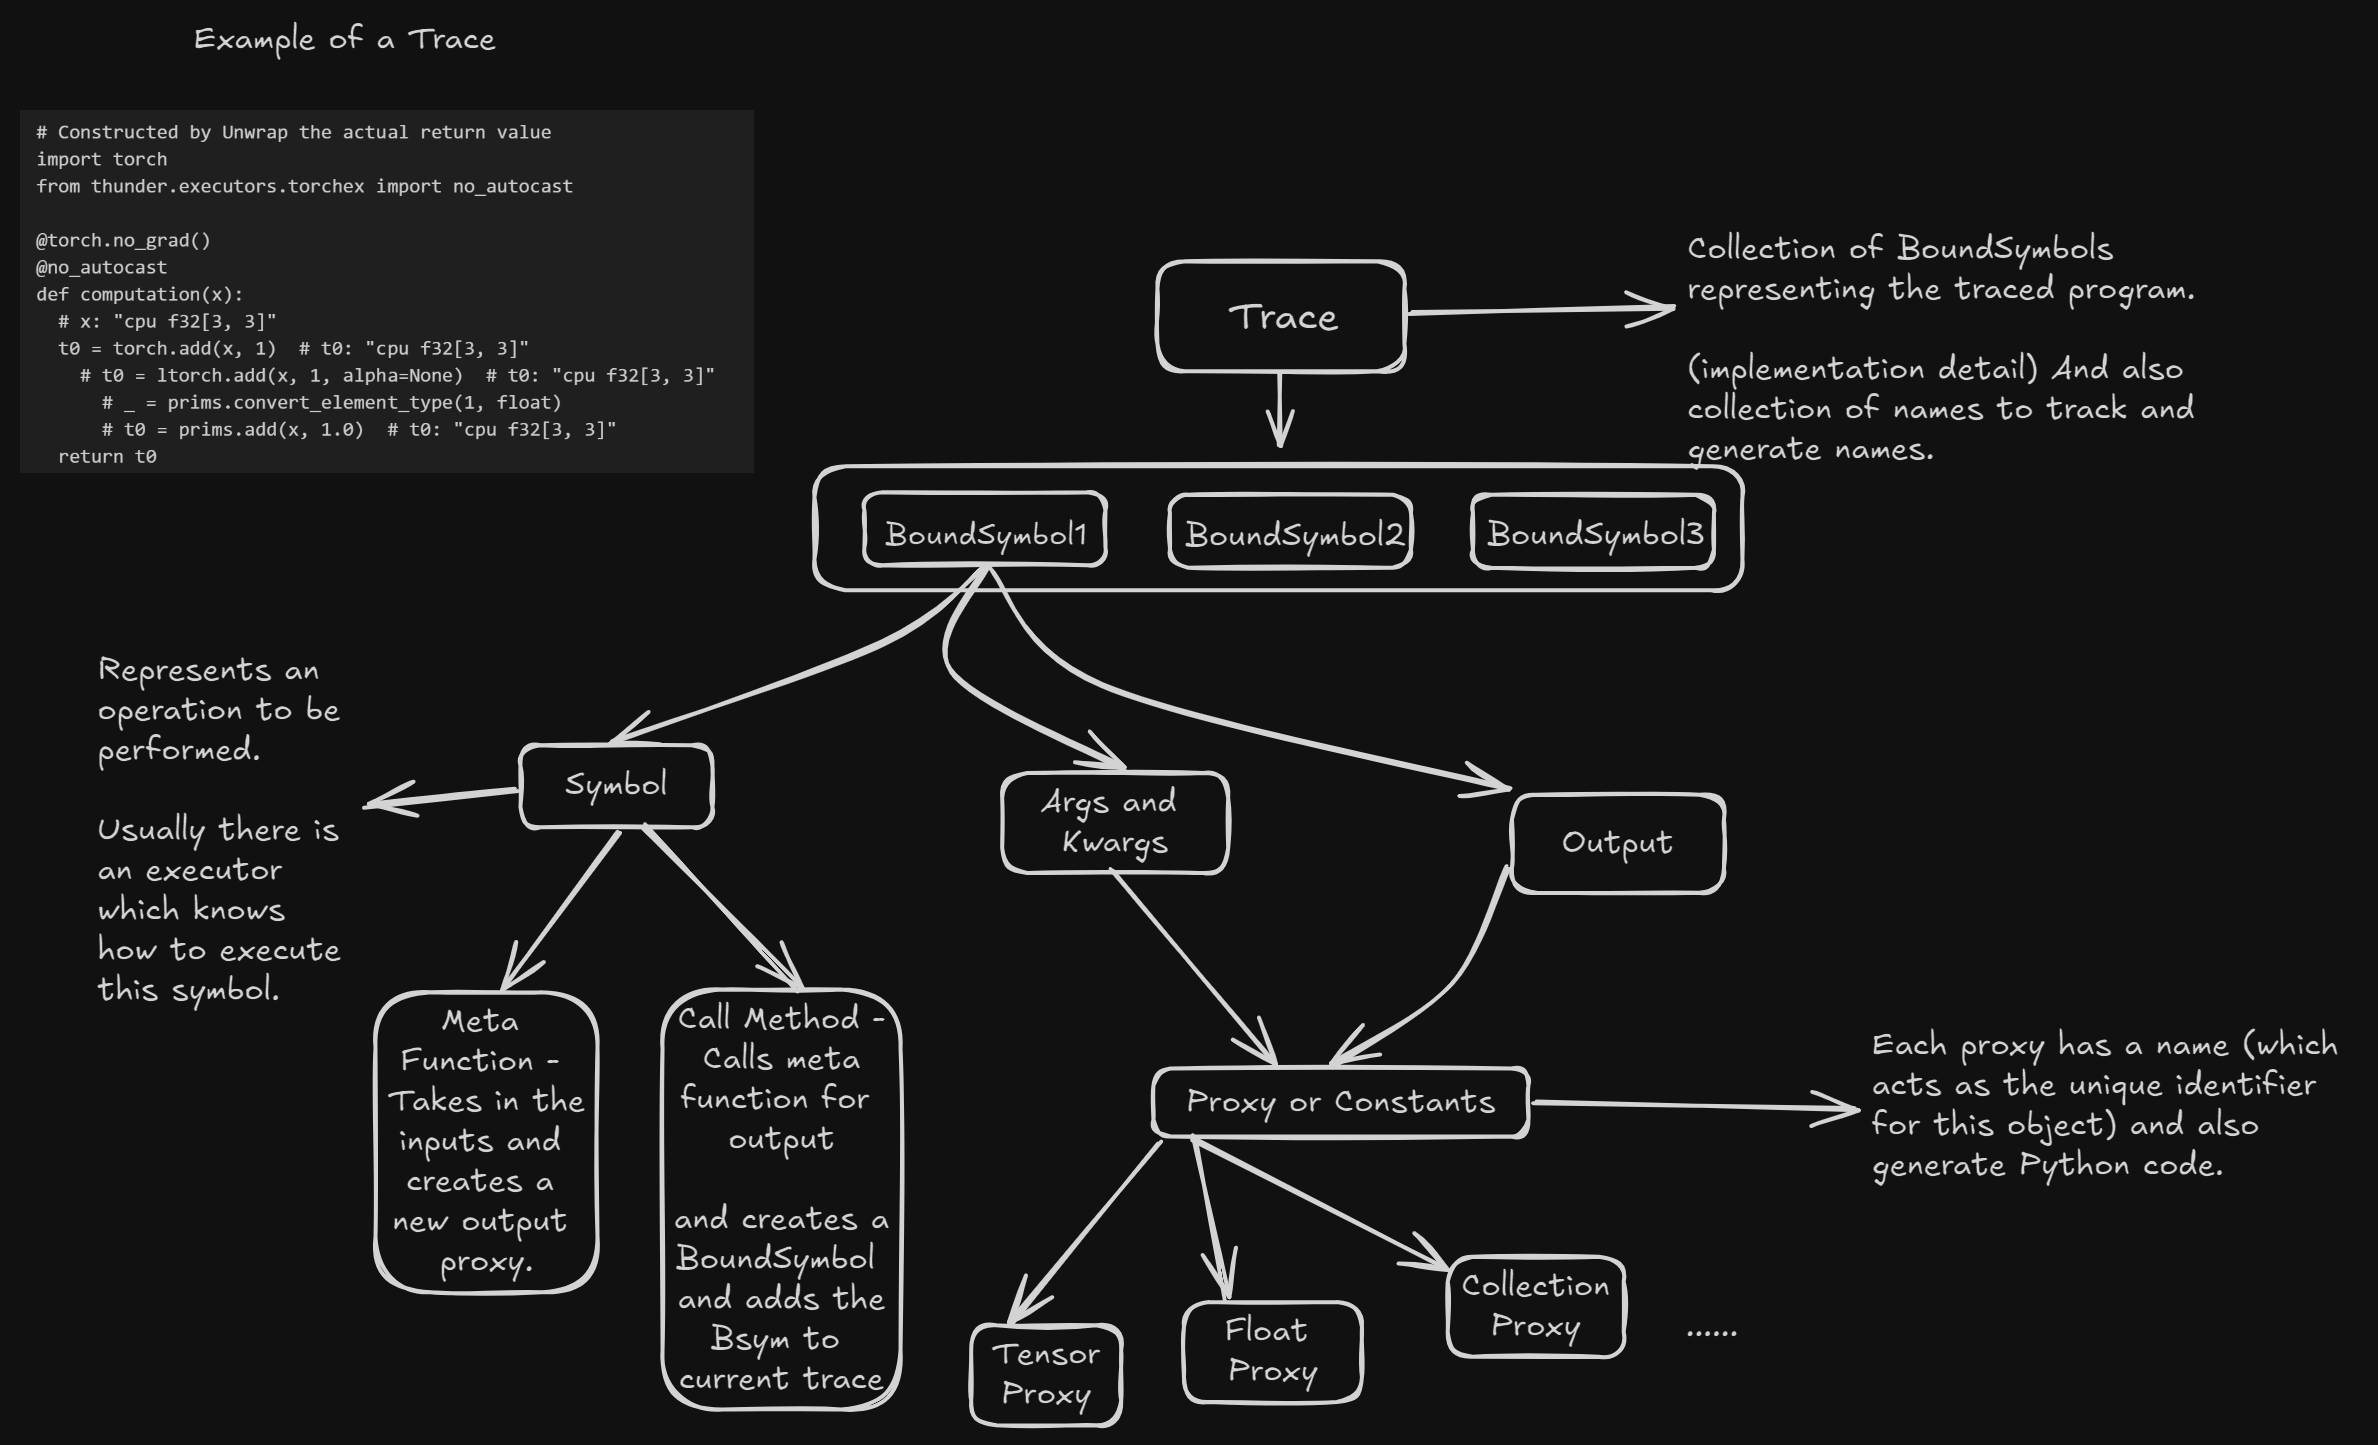

In [1]:
import thunder
import torch

from thunder.core.symbol import BoundSymbol, Symbol
from thunder.core.proxies import TensorProxy

In [2]:
# Our basic function which we will pass to thunder.
def fn(x, y):
    return torch.add(x, y)

x = torch.randn(3, 3)
y = torch.randn(3, 3, 3)
jfn = thunder.jit(fn)
o = jfn(x, y)

#### Printing an actual trace

In [3]:
# Grab the execution trace.
exec_trace = thunder.last_traces(jfn)[-1]
exec_trace

# Constructed by Unwrap the actual return value
import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast
def computation(x, y):
  # x: "cpu f32[3, 3]"
  # y: "cpu f32[3, 3, 3]"
  t1 = torch.add(x, y, alpha=1)  # t1: "cpu f32[3, 3, 3]"
    # t1 = ltorch.add(x, y, alpha=1)  # t1: "cpu f32[3, 3, 3]"
      # t4 = prims.broadcast_in_dim(x, (3, 3, 3), (1, 2))  # t4: "cpu f32[3, 3, 3]"
      # t1 = prims.add(t4, y)  # t1: "cpu f32[3, 3, 3]"
  return t1

#### Components of Trace

Zooming a bit on the trace part of the image above, we can see that a Trace is a collection of Bound Symbols. So let's see what Bound Symbols are present in our trace.
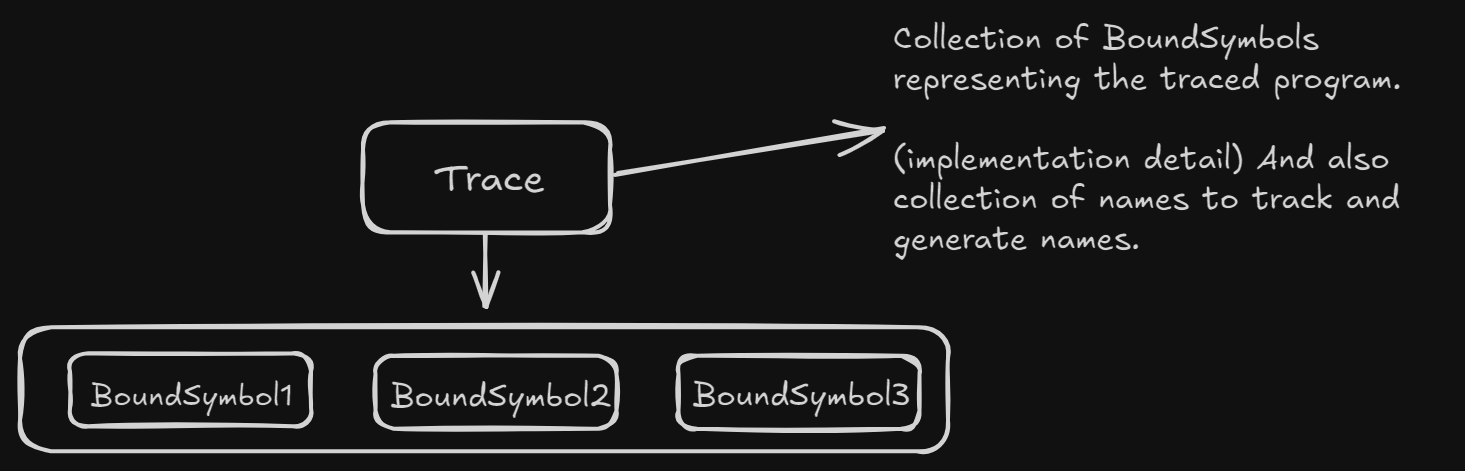

In [4]:
# Grab the BoundSymbols from our trace.
# `trace.bound_symbols` is a collection of List
bound_symbols: list[BoundSymbol] = exec_trace.bound_symbols

It also tracks all the names of variables that form the trace. This is important to avoid name-collision when we manipulate a trace. More on where the names come from in a later section about Proxies

In [5]:
# We can verify that these are all the names that showed up above when we printed the trace.
exec_trace.names

{'t0', 't1', 't2', 't3', 't4', 't5', 't_0', 't_1', 'x', 'y'}

We will iterate over these Bound Symbols and print them one by one.

In [6]:
# As we can see, we have printed the whole trace just one BoundSymbol at a time.
# This is roughly what happens when we print the trace i.e. we just iterate over all the 
# bound symbols and accumulate the string representation for the Trace
for bsym in bound_symbols:
    print(bsym)
    print("----------")

# x: "cpu f32[3, 3]"
----------
# y: "cpu f32[3, 3, 3]"
----------
t1 = torch.add(x, y, alpha=1)  # t1: "cpu f32[3, 3, 3]"
  # t1 = ltorch.add(x, y, alpha=1)  # t1: "cpu f32[3, 3, 3]"
    # t4 = prims.broadcast_in_dim(x, (3, 3, 3), (1, 2))  # t4: "cpu f32[3, 3, 3]"
    # t1 = prims.add(t4, y)  # t1: "cpu f32[3, 3, 3]"
----------
return t1
----------


#### BoundSymbol

Looking at what makes up a `BoundSymbol` from the image above, we can see that a `BoundSymbol` consists of a `Symbol`, `Args and Kwargs` and `Output`. So, `BoundSymbol` represents a computation with the binded arguments and the output.

We can query these details on the `BoundSymbol` object. Now, we will try to see these components for the BoundSymbols we got from the trace.
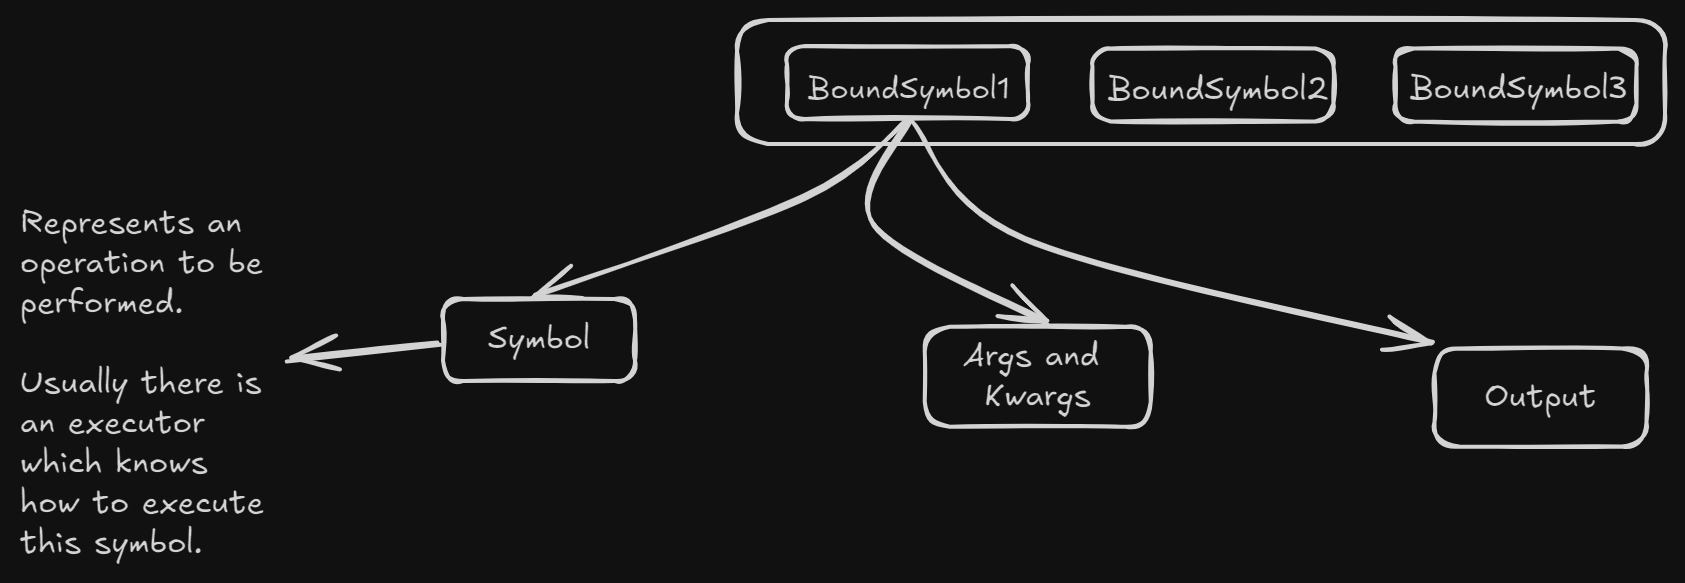

In [7]:
for bsym in bound_symbols:
    print(f"BoundSymbol - sym {bsym.sym} - args {bsym.args} - kwargs {bsym.kwargs} - output {bsym.output}")
    print("----------")

BoundSymbol - sym [Symbol name=unpack_trivial] - args () - kwargs {'name': 't_0'} - output <TensorProxy(name="x", dtype=thunder.dtypes.float32, shape=(3, 3))>
----------
BoundSymbol - sym [Symbol name=unpack_trivial] - args () - kwargs {'name': 't_1'} - output <TensorProxy(name="y", dtype=thunder.dtypes.float32, shape=(3, 3, 3))>
----------
BoundSymbol - sym [Symbol name=add] - args (<TensorProxy(name="x", dtype=thunder.dtypes.float32, shape=(3, 3))>, <TensorProxy(name="y", dtype=thunder.dtypes.float32, shape=(3, 3, 3))>) - kwargs {'alpha': 1} - output <TensorProxy(name="t1", dtype=thunder.dtypes.float32, shape=(3, 3, 3))>
----------
BoundSymbol - sym [Symbol name=python_return] - args (<TensorProxy(name="t1", dtype=thunder.dtypes.float32, shape=(3, 3, 3))>,) - kwargs {} - output None
----------


Let's focus on the BoundSymbol for `add` and look more into it's details.

In [8]:
add_bsym = bound_symbols[2]
print(f"Sym {add_bsym.sym}")  # Symbol represents the computation
print(f"Args {add_bsym.args}")  # Arguments for the computation
print(f"Kwargs {add_bsym.kwargs}")
print(f"Output {add_bsym.output}")  # Output of the computation

Sym [Symbol name=add]
Args (<TensorProxy(name="x", dtype=thunder.dtypes.float32, shape=(3, 3))>, <TensorProxy(name="y", dtype=thunder.dtypes.float32, shape=(3, 3, 3))>)
Kwargs {'alpha': 1}
Output <TensorProxy(name="t1", dtype=thunder.dtypes.float32, shape=(3, 3, 3))>


#### Symbol

Let us now look what is a `Symbol`. As mentioned above `Symbol` represents an operation to be performed on it's inputs. It is comprises of an `id` and meta function. Meta function takes in inputs and returns an output but the inputs and outputs are not concrete objects but a proxy representation of the same. That is why the name meta-function.

Also, `Symbol` itself doesn't perform the computation (usually) but just represents what the computation will be. There are `Executors` (not part of this notebook) which provide implementation for the `Symbol`.

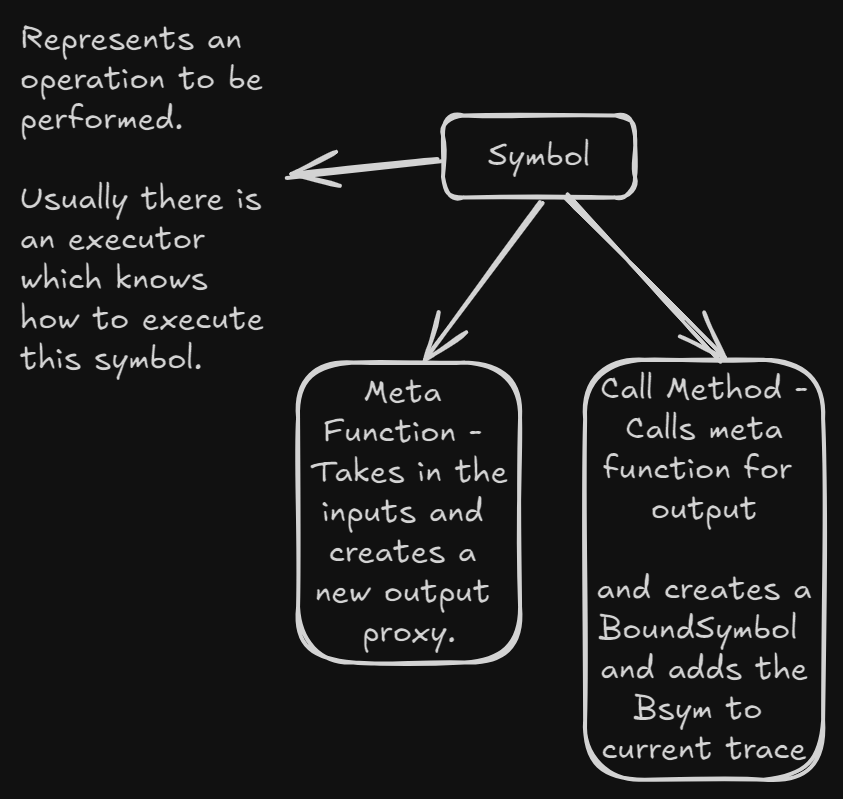

In [20]:
sym: Symbol = add_bsym.sym

print(f"Symbol Id - {sym.id}")

# Symbol has a meta function which takes in the input and returns output.
# These inputs and outputs are usually Proxy object (see below)
# NOTE - We won't execute as we need to be in tracing context (we will see this below)
# sym.meta(add_bsym.args[0], add_bsym.args[1])

Symbol Id - torch.add


#### Proxies

Zooming in on the part for args and kwargs are Proxies or constants, we can see that these objects have a name

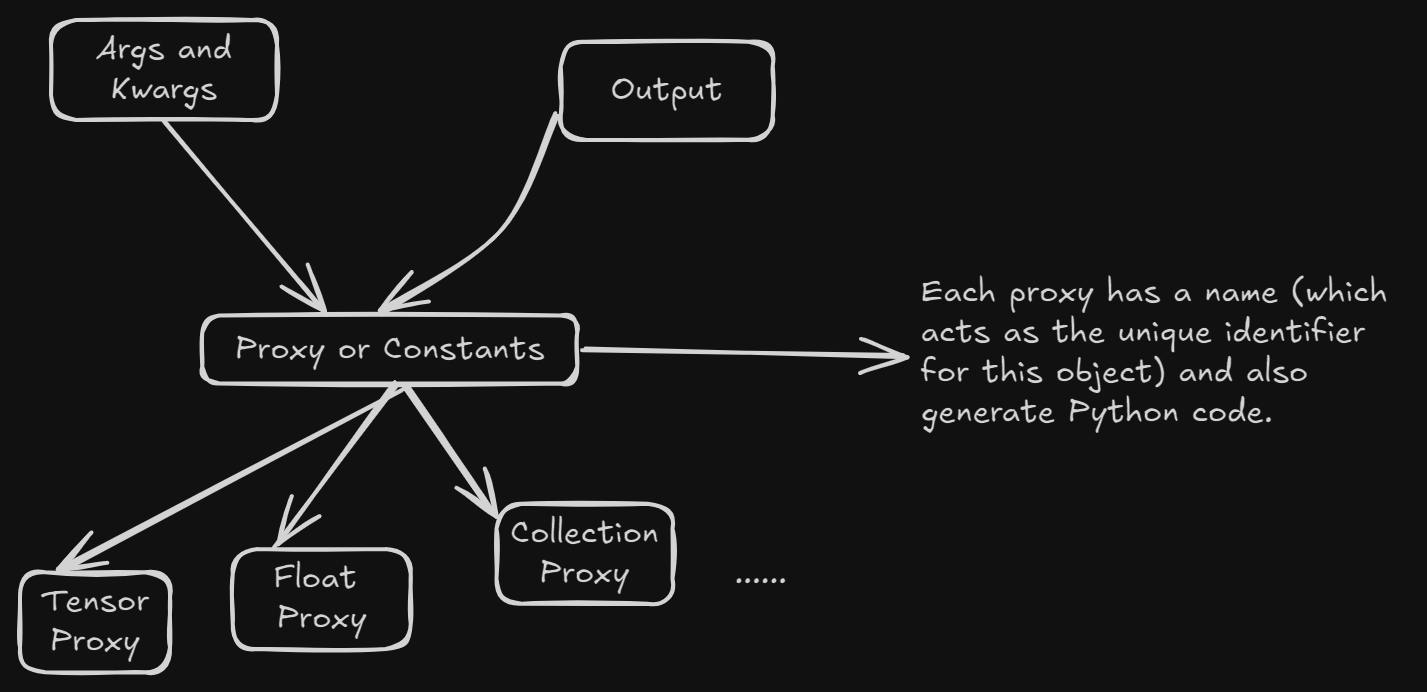

Also, in the output of above cell, we can see that arguments are something called TensorProxy.

Proxies represent an actual Python object in an abstract sense providing only the attributes which are required while tracing and reasoning about the program. Regarding a Tensor, we only care about the shape, ndim, device, dtype but not the actual data to represent our program and reason about our program. This way, we get a light-weight representation of the object and we can easily create multiple copies for manipulation if required.

Let us grab these proxies and inspect them.


In [10]:
x_proxy: TensorProxy = add_bsym.args[0]
y_proxy: TensorProxy = add_bsym.args[1]

As expected, we can see that these proxies model a tensor without actually containing the actual data.

In [11]:
print(f"name {x_proxy.name} - shape {x_proxy.shape} - ndim {x_proxy.ndim} - device {x_proxy.device}")

name x - shape (3, 3) - ndim 2 - device thunder.devices.Device(type='cpu')


In [12]:
print(f"name {y_proxy.name} - shape {y_proxy.shape} - ndim {y_proxy.ndim} - device {y_proxy.device}")

name y - shape (3, 3, 3) - ndim 3 - device thunder.devices.Device(type='cpu')


#### Constructing a Trace

Now that we understand each component, let's try to assemble the trace we see above by hand.

In [13]:
# Imports required for assembling our trace
from thunder.core.proxies import TensorProxy
from thunder.core.trace import TraceCtx as Trace, tracectx
from thunder.core.devices import Device
from thunder.core.dtypes import float32
from thunder.core.prims import python_return
from thunder.core.symbol import BoundSymbol
from thunder.core.codeutils import SigInfo

In [14]:
trc = Trace()  # Create an empty trace

In [15]:
# Print the trace.
# There is nothing interesting in it.
trc

import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast
# No signature available

##### Creating a Trace - Manually adding BoundSymbols

In [16]:
# Set tracing context to `trc` trace.
# Any information related to trace, will be looked from or added to `trc` trace.
with tracectx(trc):
    # Create proxies
    x = TensorProxy("x", shape=(3, 3), device=Device("cpu"), dtype=float32, requires_grad=False)
    y = TensorProxy("y", shape=(3, 3, 3), device=Device("cpu"), dtype=float32, requires_grad=False)

    # In this tutorial, we will re-use one of the existing symbols that already exists.
    from thunder.torch import add
    o = add.meta(x, y)

    # Create BoundSymbol
    add_bsym = BoundSymbol(sym=add, args=(x, y), kwargs={}, output=o)
    return_bsym = BoundSymbol(sym=python_return, args=(o,), kwargs={}, output=None)

trc_args = (x, y)

si = SigInfo("my_trace")
si.args = [(v.name, None) for v in trc_args]
trc._siginfo = si

# Connect trace and bound symbols
trc.bound_symbols = [add_bsym, return_bsym]

In [17]:
trc

import thunder
import thunder.torch as ltorch
import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast
def my_trace(x, y):
  t1 = ltorch.add(x, y)  # t1: "cpu f32[3, 3, 3]"
  return t1

##### Other way to create this trace - Calling Symbols with Proxies

In [18]:
trc = Trace()  # Empty Trace

# Set tracing context to `trc` trace.
# Any information related to trace, will be looked from or added to `trc` trace.
with tracectx(trc):
    # Create proxies
    x = TensorProxy("x", shape=(3, 3), device=Device("cpu"), dtype=float32, requires_grad=False)
    y = TensorProxy("y", shape=(3, 3, 3), device=Device("cpu"), dtype=float32, requires_grad=False)
    o = TensorProxy("output", shape=(3, 3, 3), device=Device("cpu"), dtype=float32, requires_grad=False)

    # Here we know, what symbol is being called, what the args and kwargs are and what the output was
    # (by calling the meta function),
    # a BoundSymbol is added to the trace.
    o = add(x, y)
    python_return(o)

trc_args = (x, y)

si = SigInfo("my_trace")
si.args = [(v.name, None) for v in trc_args]
trc._siginfo = si

In [19]:
trc

import thunder
import thunder.torch as ltorch
import torch
from thunder.executors.torchex import no_autocast

@torch.no_grad()
@no_autocast
def my_trace(x, y):
  t1 = ltorch.add(x, y, alpha=1)  # t1: "cpu f32[3, 3, 3]"
    # t0 = prims.broadcast_in_dim(x, (3, 3, 3), (1, 2))  # t0: "cpu f32[3, 3, 3]"
    # t1 = prims.add(t0, y)  # t1: "cpu f32[3, 3, 3]"
  return t1

Now that we know how to construct a trace, this opens a lot of interesting manipulation that we can do. For example 1. we can generate a trace computing backward trace for a given trace by iterating over all the symbols and replacing them with corresponding symbols that implement the correct gradient rule, 2. we can also re-order the computation for more efficient compute, 3. we can replace a pattern of symbol with another faster implementation.